# Linearly decoded VAE
Better explainibility than scVI because it enforces that the higher value along a latent dimension will directly correspond to higher expression of the genes with high weights assigned to that dimension.
## References:
- https://docs.scvi-tools.org/en/stable/tutorials/notebooks/scrna/linear_decoder.html

In [1]:
import os
import tempfile

import matplotlib.pyplot as plt
import scanpy as sc
import scvi
import seaborn as sns
import torch
import numpy as np

/home/amon/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.3.3


In [3]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

In [4]:
alldata = sc.read_h5ad("431c764c-3d1f-4ba8-bcb0-b18de3966978.h5ad")

np.random.seed(42)
adata = alldata[np.random.choice(alldata.n_obs, 3000, replace=False), :].copy()

scvi.model.SCVI.setup_anndata(adata)

/home/amon/.local/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [5]:
alldata = None

In [6]:
adata.layers["counts"] = adata.X.copy()  # preserve counts
#sc.pp.normalize_total(adata, target_sum=10e4)
#sc.pp.log1p(adata)
adata.raw = adata  # freeze the state in `.raw`

sc.pp.highly_variable_genes(
    adata, flavor="seurat_v3", layer="counts", n_top_genes=600, subset=True
)

/home/amon/.local/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:373: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
/home/amon/.local/lib/python3.10/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)


In [8]:
adata.X.shape

(3000, 600)

In [9]:
scvi.model.LinearSCVI.setup_anndata(adata, layer="counts")
model = scvi.model.LinearSCVI(adata, n_latent=10)

/home/amon/.local/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [10]:
model.train(max_epochs=250, plan_kwargs={"lr": 5e-3}, check_val_every_n_epoch=10)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/amon/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training:   0%|          | 0/250 [00:00<?, ?it/s]

/home/amon/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
`Trainer.fit` stopped: `max_epochs=250` reached.


<Axes: xlabel='epoch'>

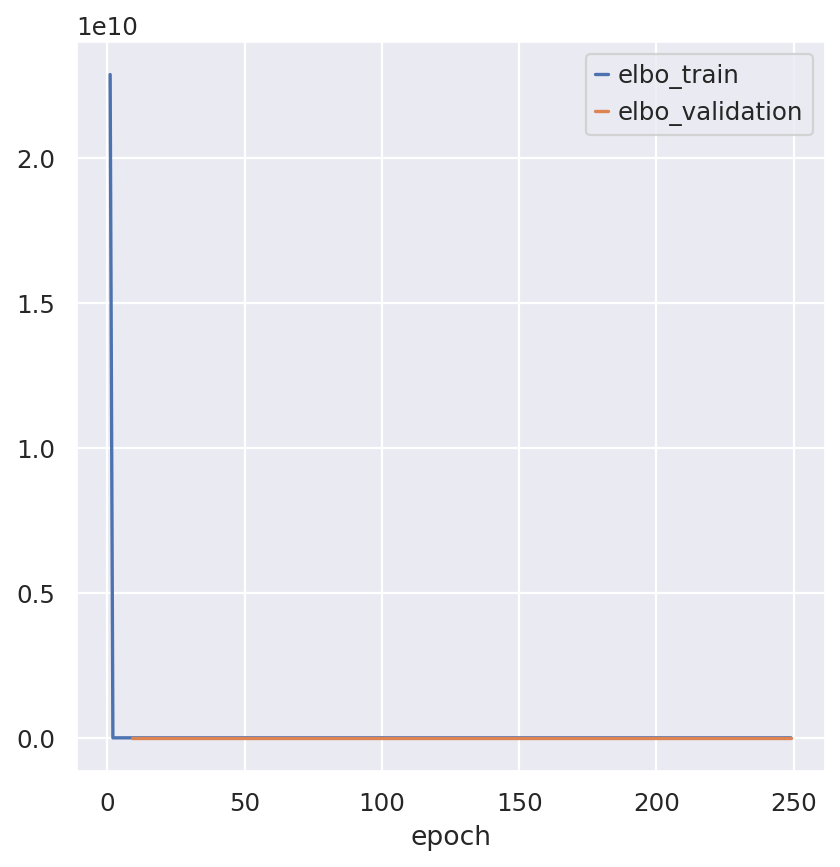

In [11]:
train_elbo = model.history["elbo_train"][1:]
test_elbo = model.history["elbo_validation"]

ax = train_elbo.plot()
test_elbo.plot(ax=ax)

In [12]:
Z_hat = model.get_latent_representation()
for i, z in enumerate(Z_hat.T):
    adata.obs[f"Z_{i}"] = z

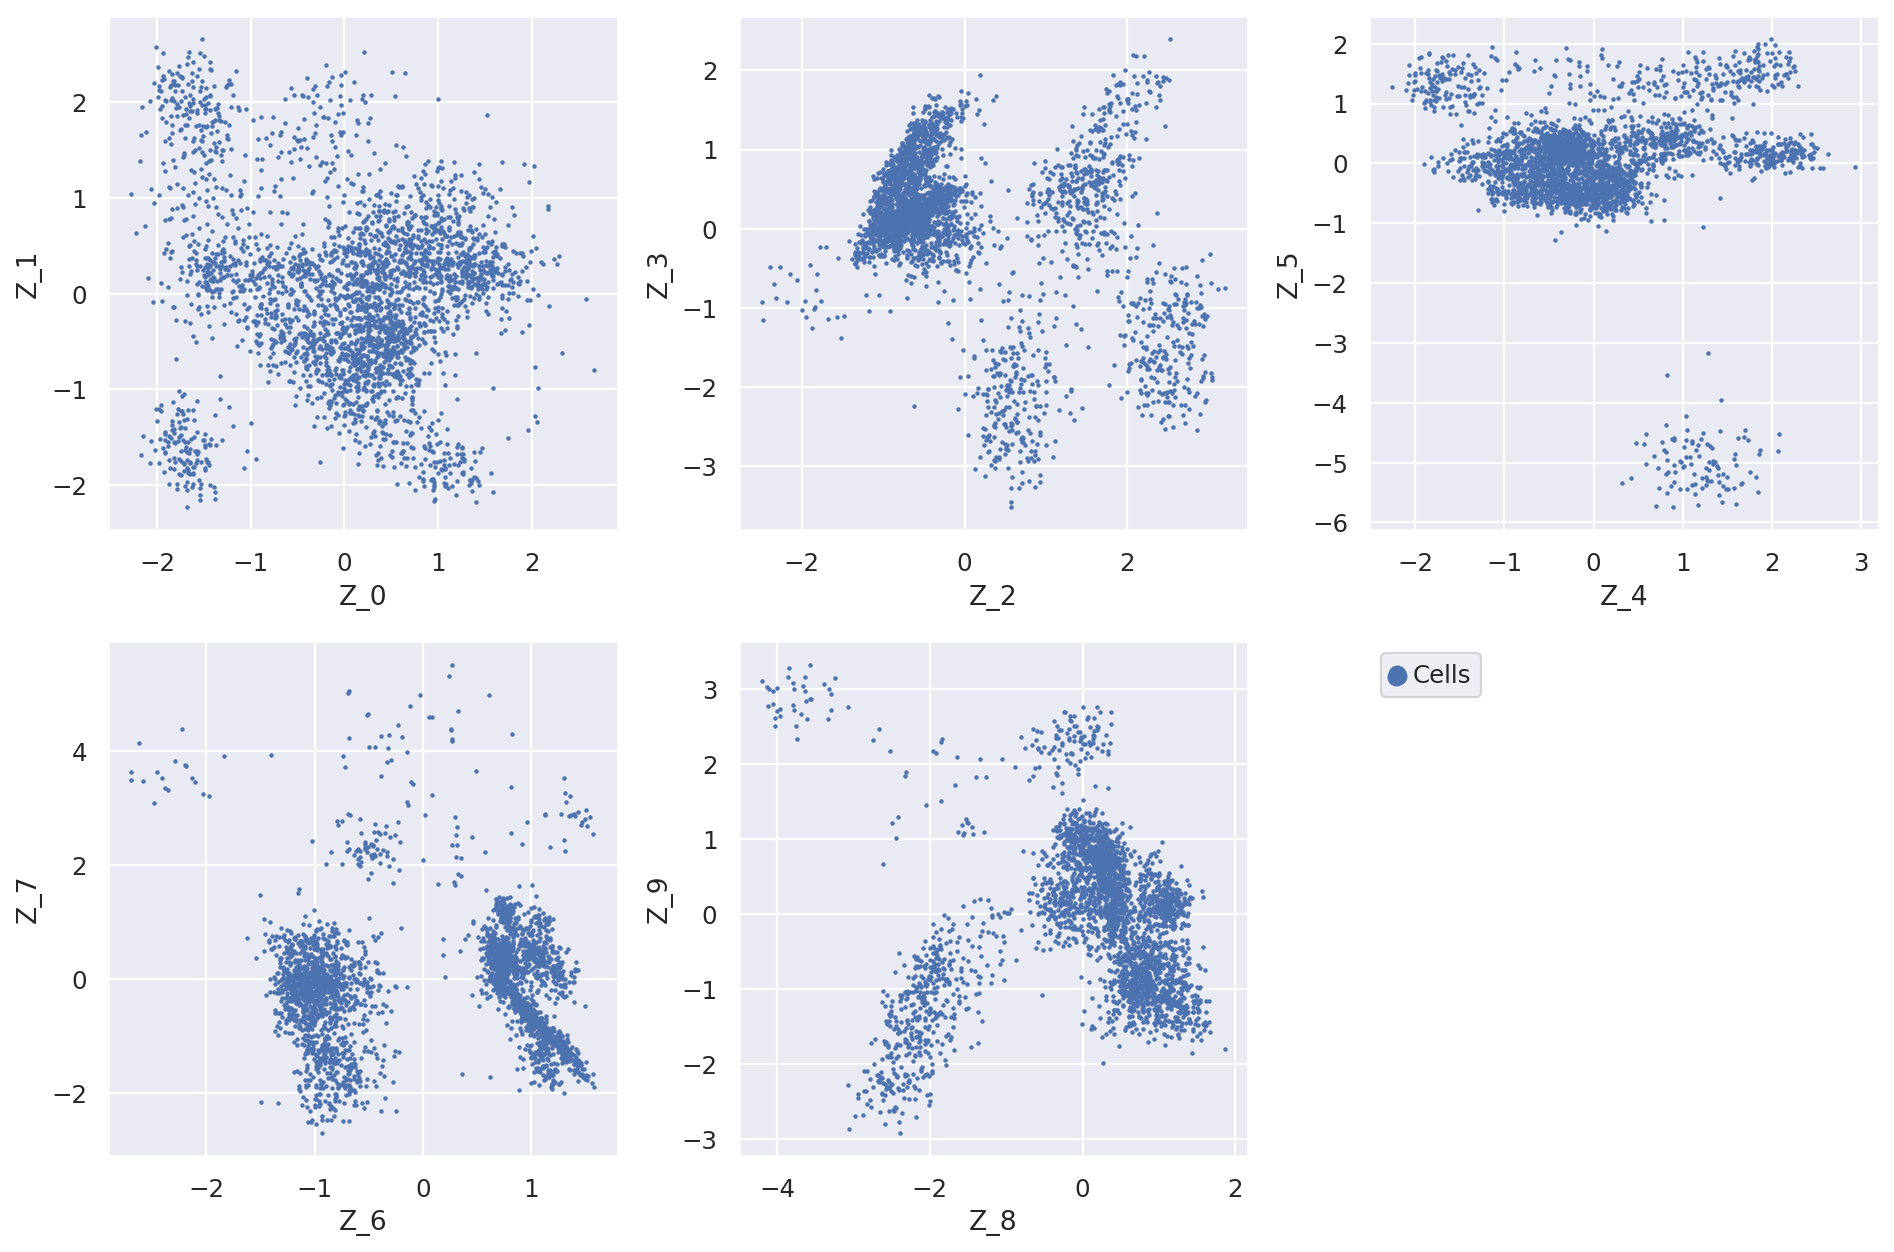

In [13]:
fig = plt.figure(figsize=(12, 8))

for f in range(0, 9, 2):
    plt.subplot(2, 3, int(f / 2) + 1)

    plt.scatter(adata.obs[f"Z_{f}"], adata.obs[f"Z_{f + 1}"], marker=".", s=4, label="Cells")

    plt.xlabel(f"Z_{f}")
    plt.ylabel(f"Z_{f + 1}")

plt.subplot(2, 3, 6)
plt.scatter(adata.obs[f"Z_{f}"], adata.obs[f"Z_{f + 1}"], marker=".", label="Cells", s=4)
plt.scatter(adata.obs[f"Z_{f}"], adata.obs[f"Z_{f + 1}"], c="w", label=None)
plt.gca().set_frame_on(False)
plt.gca().axis("off")

lgd = plt.legend(scatterpoints=3, loc="upper left")
for handle in lgd.legend_handles:
    handle.set_sizes([200])


plt.tight_layout()

In [14]:
loadings = model.get_loadings()
loadings.head()

,Z_0,Z_1,Z_2,Z_3,Z_4,Z_5,Z_6,Z_7,Z_8,Z_9
ENSG00000141338,0.059632,0.916166,-0.323927,0.044024,0.453826,-0.769853,0.075312,-0.017330,-0.067570,0.241564
ENSG00000132744,0.896397,-0.291388,0.246007,0.048834,0.048508,-0.307064,-0.113357,0.309435,-0.547658,0.552442
ENSG00000140470,-0.002956,0.393440,-0.206779,-0.101493,0.016115,0.175477,0.124331,-0.192420,-0.623689,0.056769
ENSG00000241684,-0.584257,-0.393075,0.051134,0.037896,0.023943,-0.102061,0.160751,-0.551603,-0.555588,-0.065162
ENSG00000178031,-0.119060,-0.382309,-0.267676,0.276652,0.320823,-0.331836,0.110275,-0.275580,-0.021613,-0.112815


In [15]:
print(
    "Top loadings by magnitude\n------------------------------------------------------------------"
    "---------------------"
)
for clmn_ in loadings:
    loading_ = loadings[clmn_].sort_values()
    fstr = clmn_ + ":\t"
    fstr += "\t".join([f"{i}, {loading_[i]:.2}" for i in loading_.head(5).index])
    fstr += "\n\t...\n\t"
    fstr += "\t".join([f"{i}, {loading_[i]:.2}" for i in loading_.tail(5).index])
    print(
        fstr
        + "\n-------------------------------------------------------------------------------------"
        "--\n"
    )

Top loadings by magnitude
---------------------------------------------------------------------------------------
Z_0:	ENSG00000165478, -0.88	ENSG00000162631, -0.82	ENSG00000146648, -0.81	ENSG00000120907, -0.78	ENSG00000117707, -0.77
	...
	ENSG00000169252, 0.78	ENSG00000137491, 0.78	ENSG00000104972, 0.82	ENSG00000277494, 0.87	ENSG00000132744, 0.9
---------------------------------------------------------------------------------------

Z_1:	ENSG00000134138, -0.85	ENSG00000122012, -0.62	ENSG00000187398, -0.61	ENSG00000170962, -0.6	ENSG00000182601, -0.56
	...
	ENSG00000117707, 0.8	ENSG00000198753, 0.82	ENSG00000141338, 0.92	ENSG00000105854, 0.94	ENSG00000197430, 1.0
---------------------------------------------------------------------------------------

Z_2:	ENSG00000255794, -0.87	ENSG00000135426, -0.85	ENSG00000198963, -0.84	ENSG00000172673, -0.77	ENSG00000138696, -0.76
	...
	ENSG00000232287, 0.77	ENSG00000046889, 0.77	ENSG00000017427, 0.81	ENSG00000231764, 0.82	ENSG00000198597, 0.84
----

In [117]:
SCVI_LATENT_KEY = "X_scVI"
SCVI_CLUSTERS_KEY = "leiden_scVI"

adata.obsm[SCVI_LATENT_KEY] = Z_hat
sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY, n_neighbors=30)
sc.tl.umap(adata, min_dist=0.3)
sc.tl.leiden(adata, key_added=SCVI_CLUSTERS_KEY, resolution=0.4)

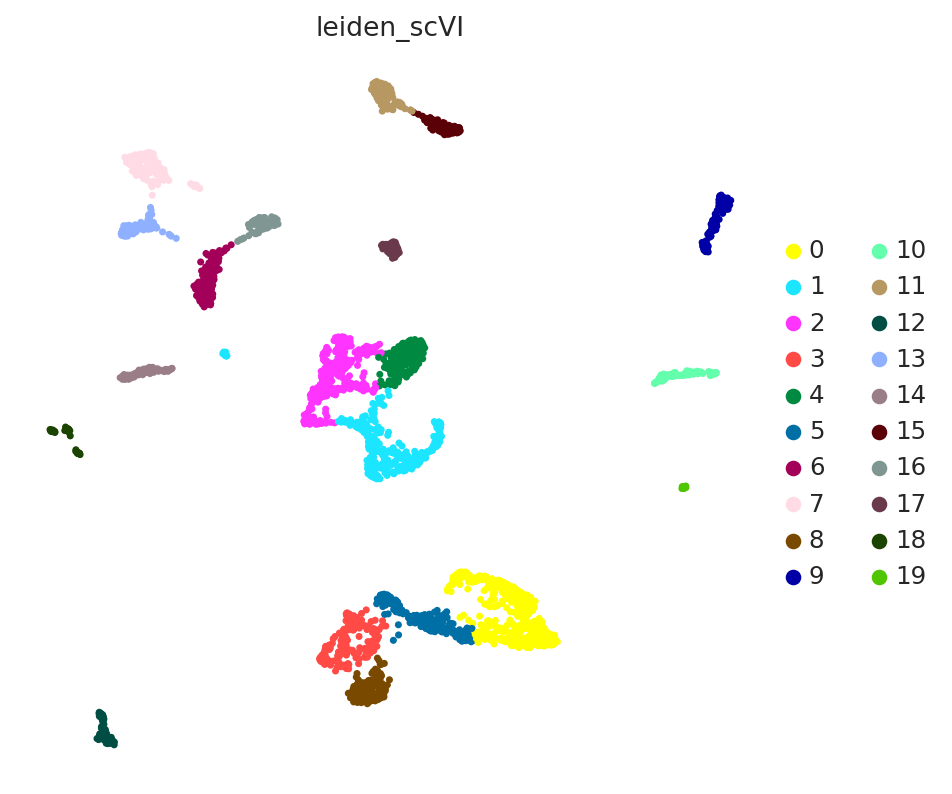

In [118]:
sc.pl.umap(adata, color=[SCVI_CLUSTERS_KEY])

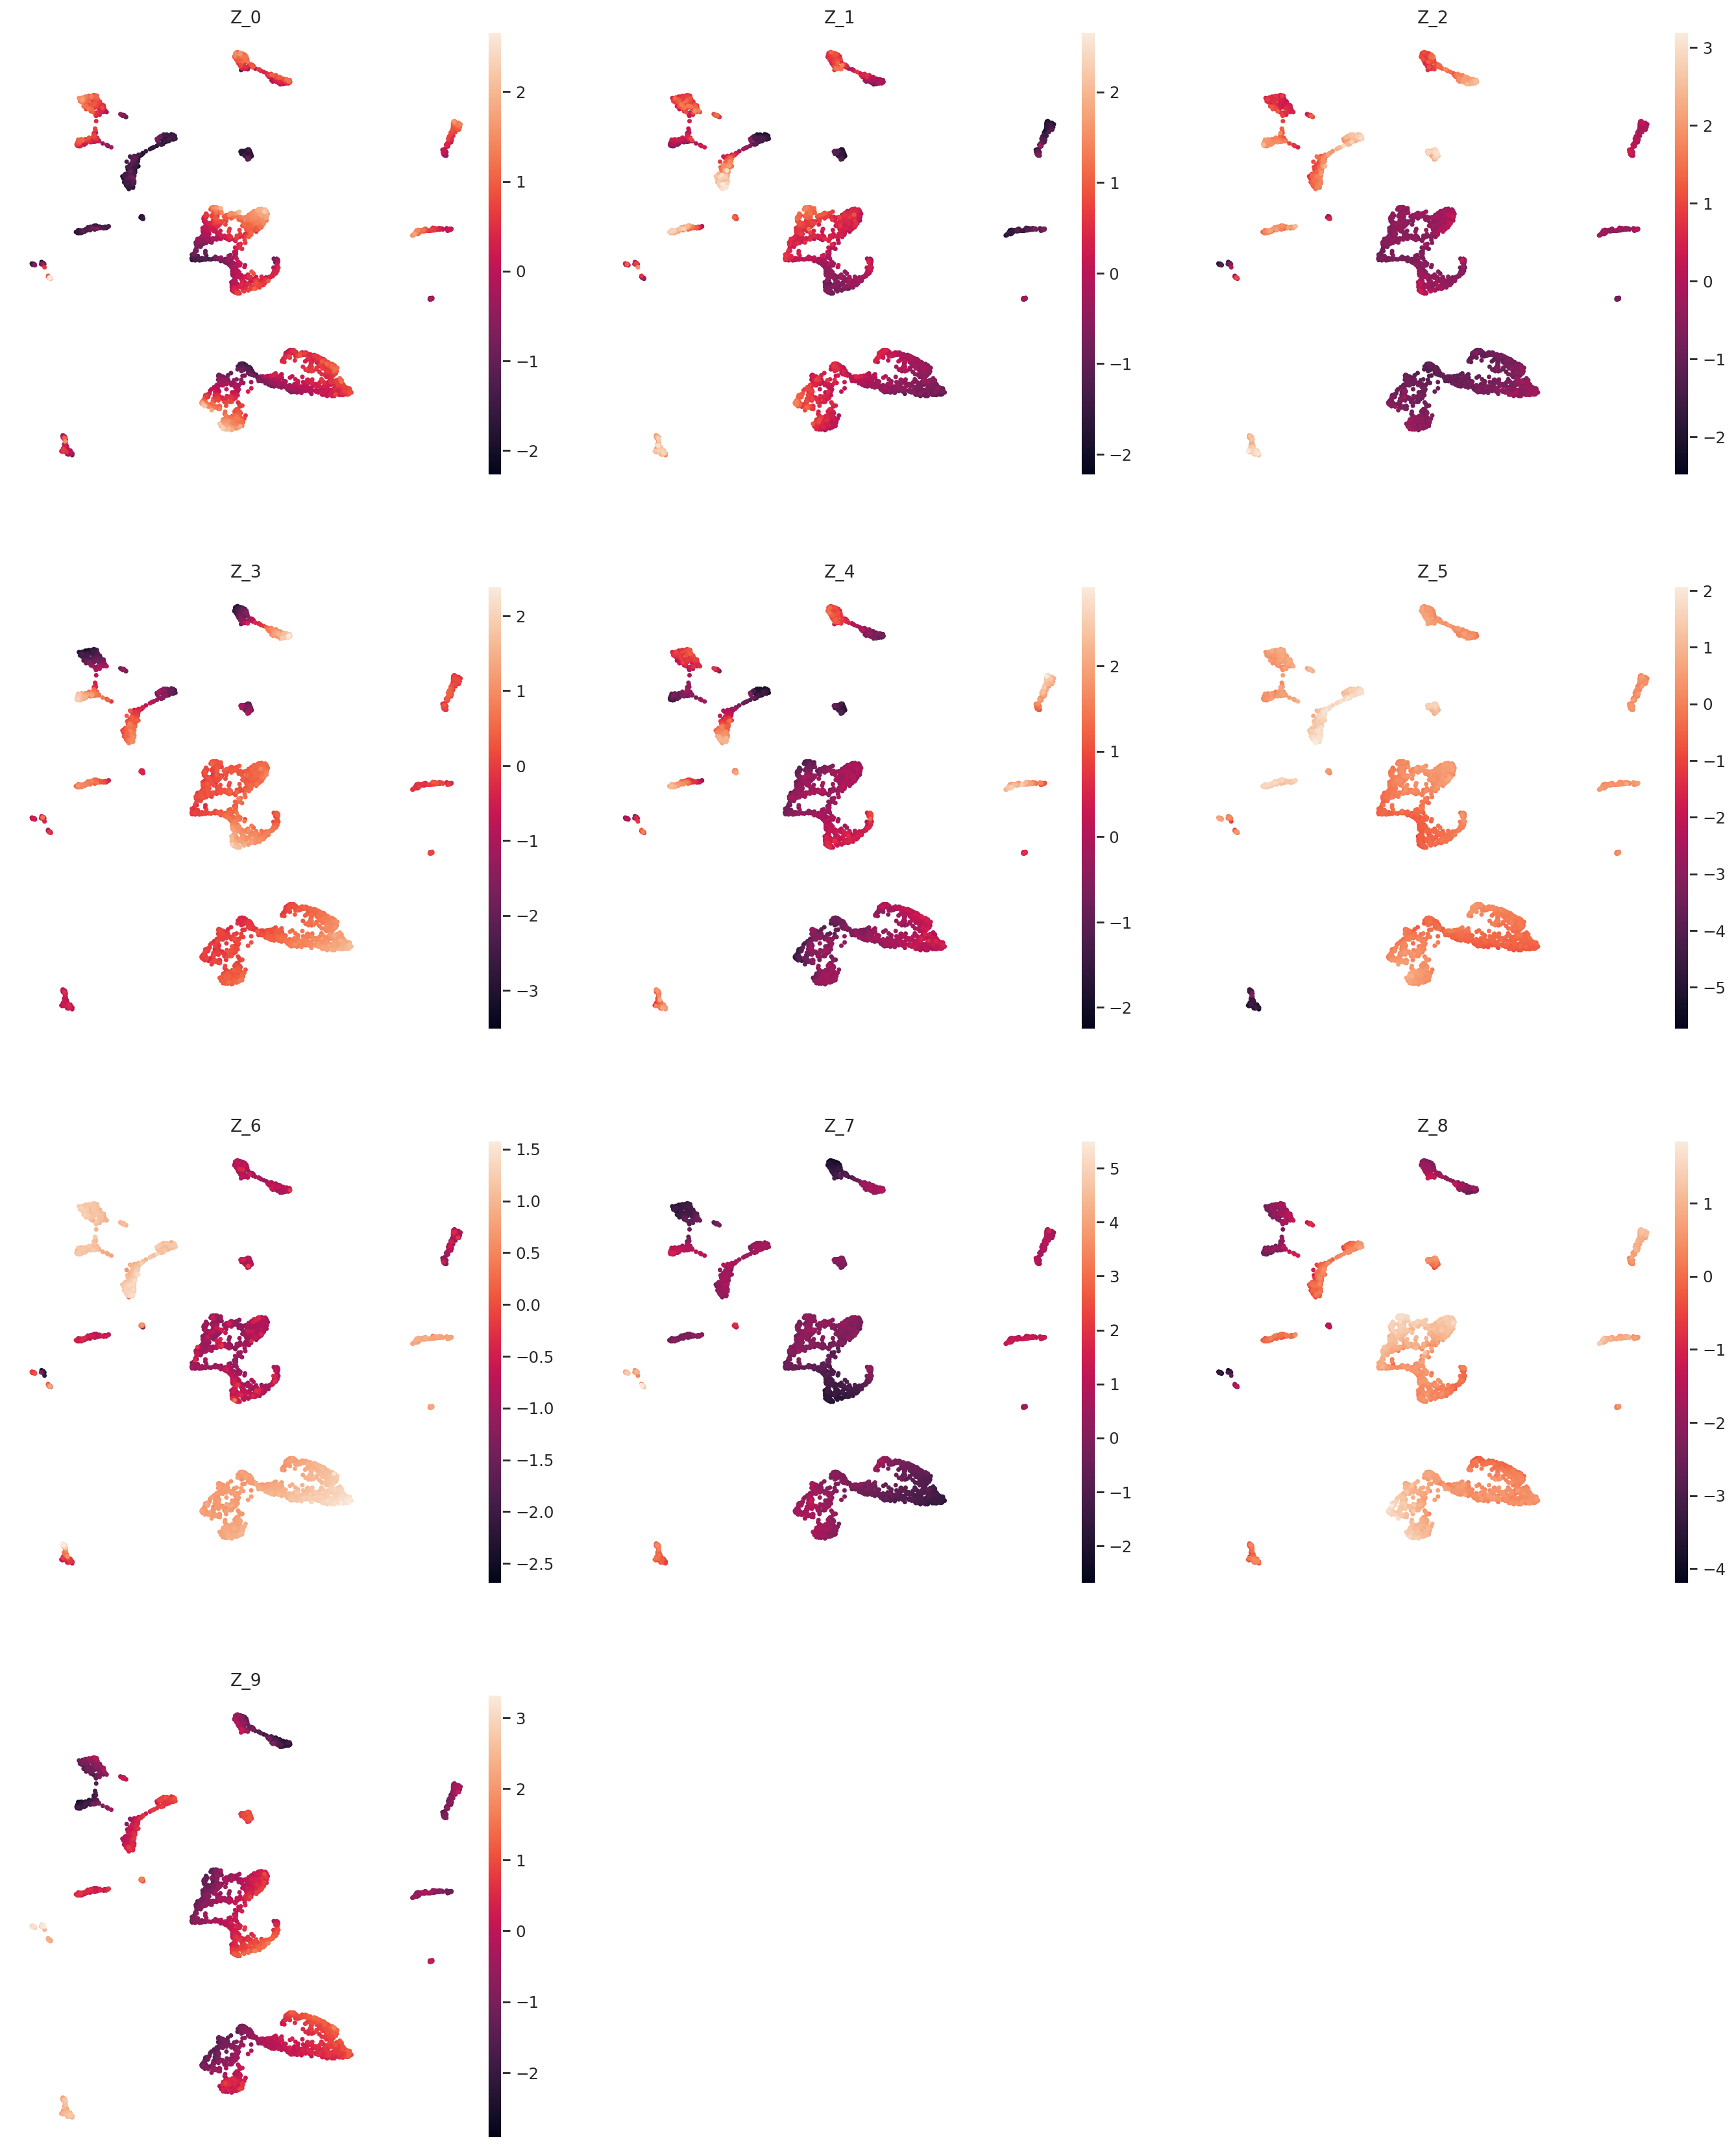

In [119]:
zs = [f"Z_{i}" for i in range(model.n_latent)]
sc.pl.umap(adata, color=zs, ncols=3)

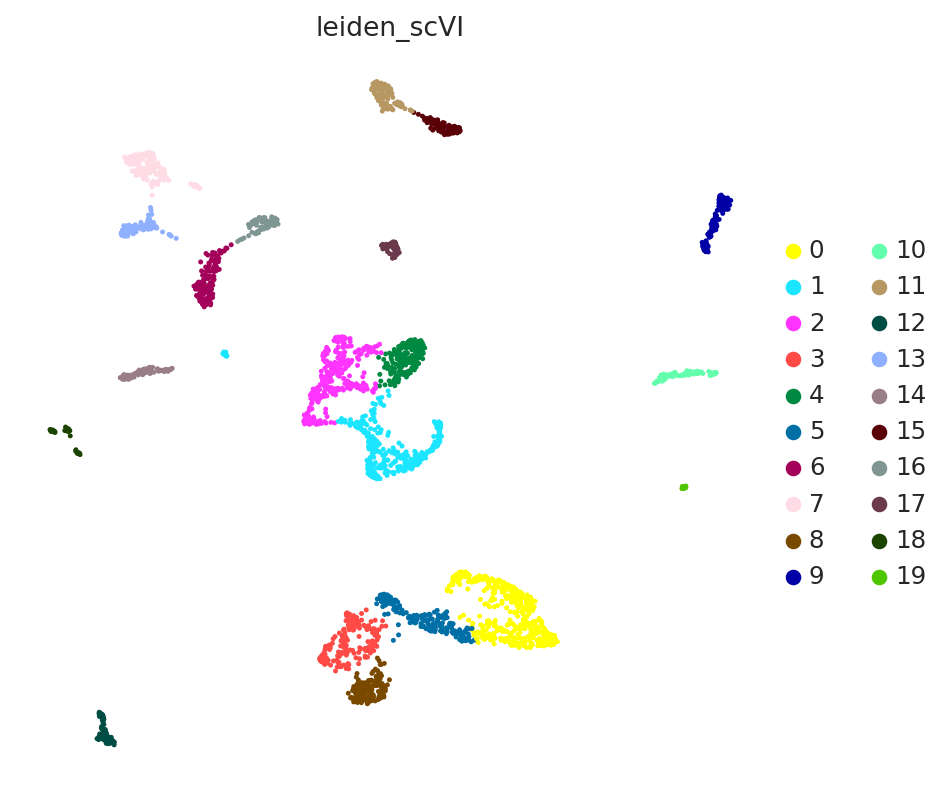

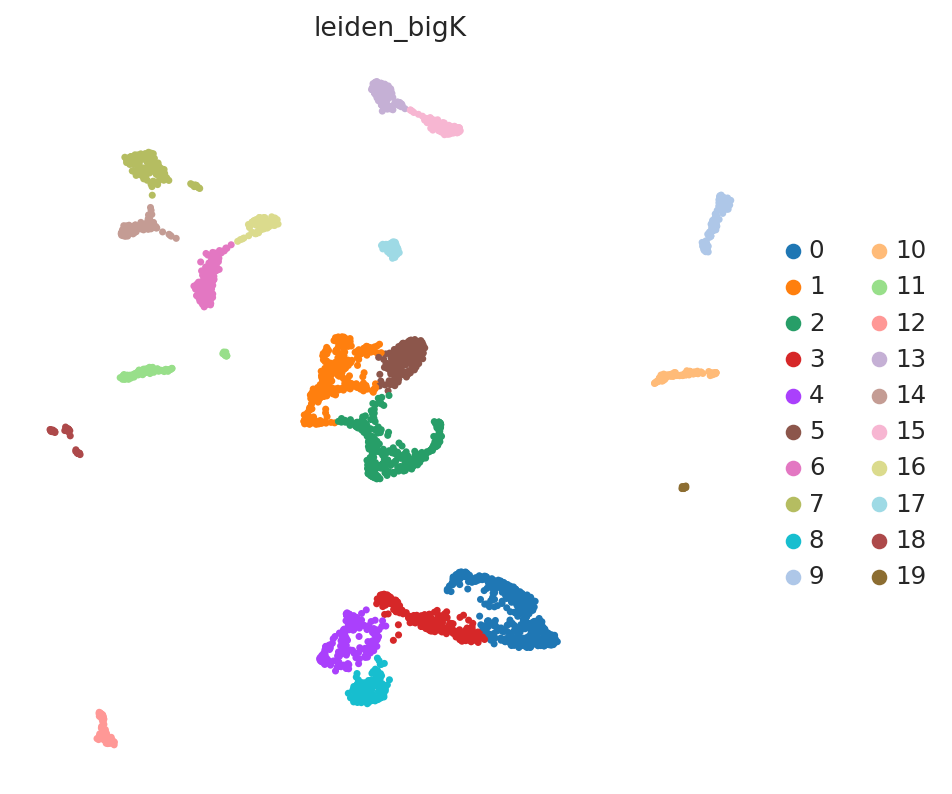

In [121]:
import pandas as pd
pd.Series(adata.obs['leiden_scVI']).value_counts().sort_index()

# 2. Look at latent UMAP colored by cluster
sc.pl.umap(adata, color='leiden_scVI', size=20)

# 3. Check if clusters correlate with technical covariates
for key in ['n_counts', 'pct_counts_mt']:
    if key in adata.obs:
        sc.pl.umap(adata, color=[key, 'leiden_scVI'])

# 4. Try increasing n_neighbors to see if clusters merge
sc.pp.neighbors(adata, use_rep='X_scVI', n_neighbors=50)
sc.tl.leiden(adata, key_added='leiden_bigK', resolution=0.5)
sc.pl.umap(adata, color='leiden_bigK')


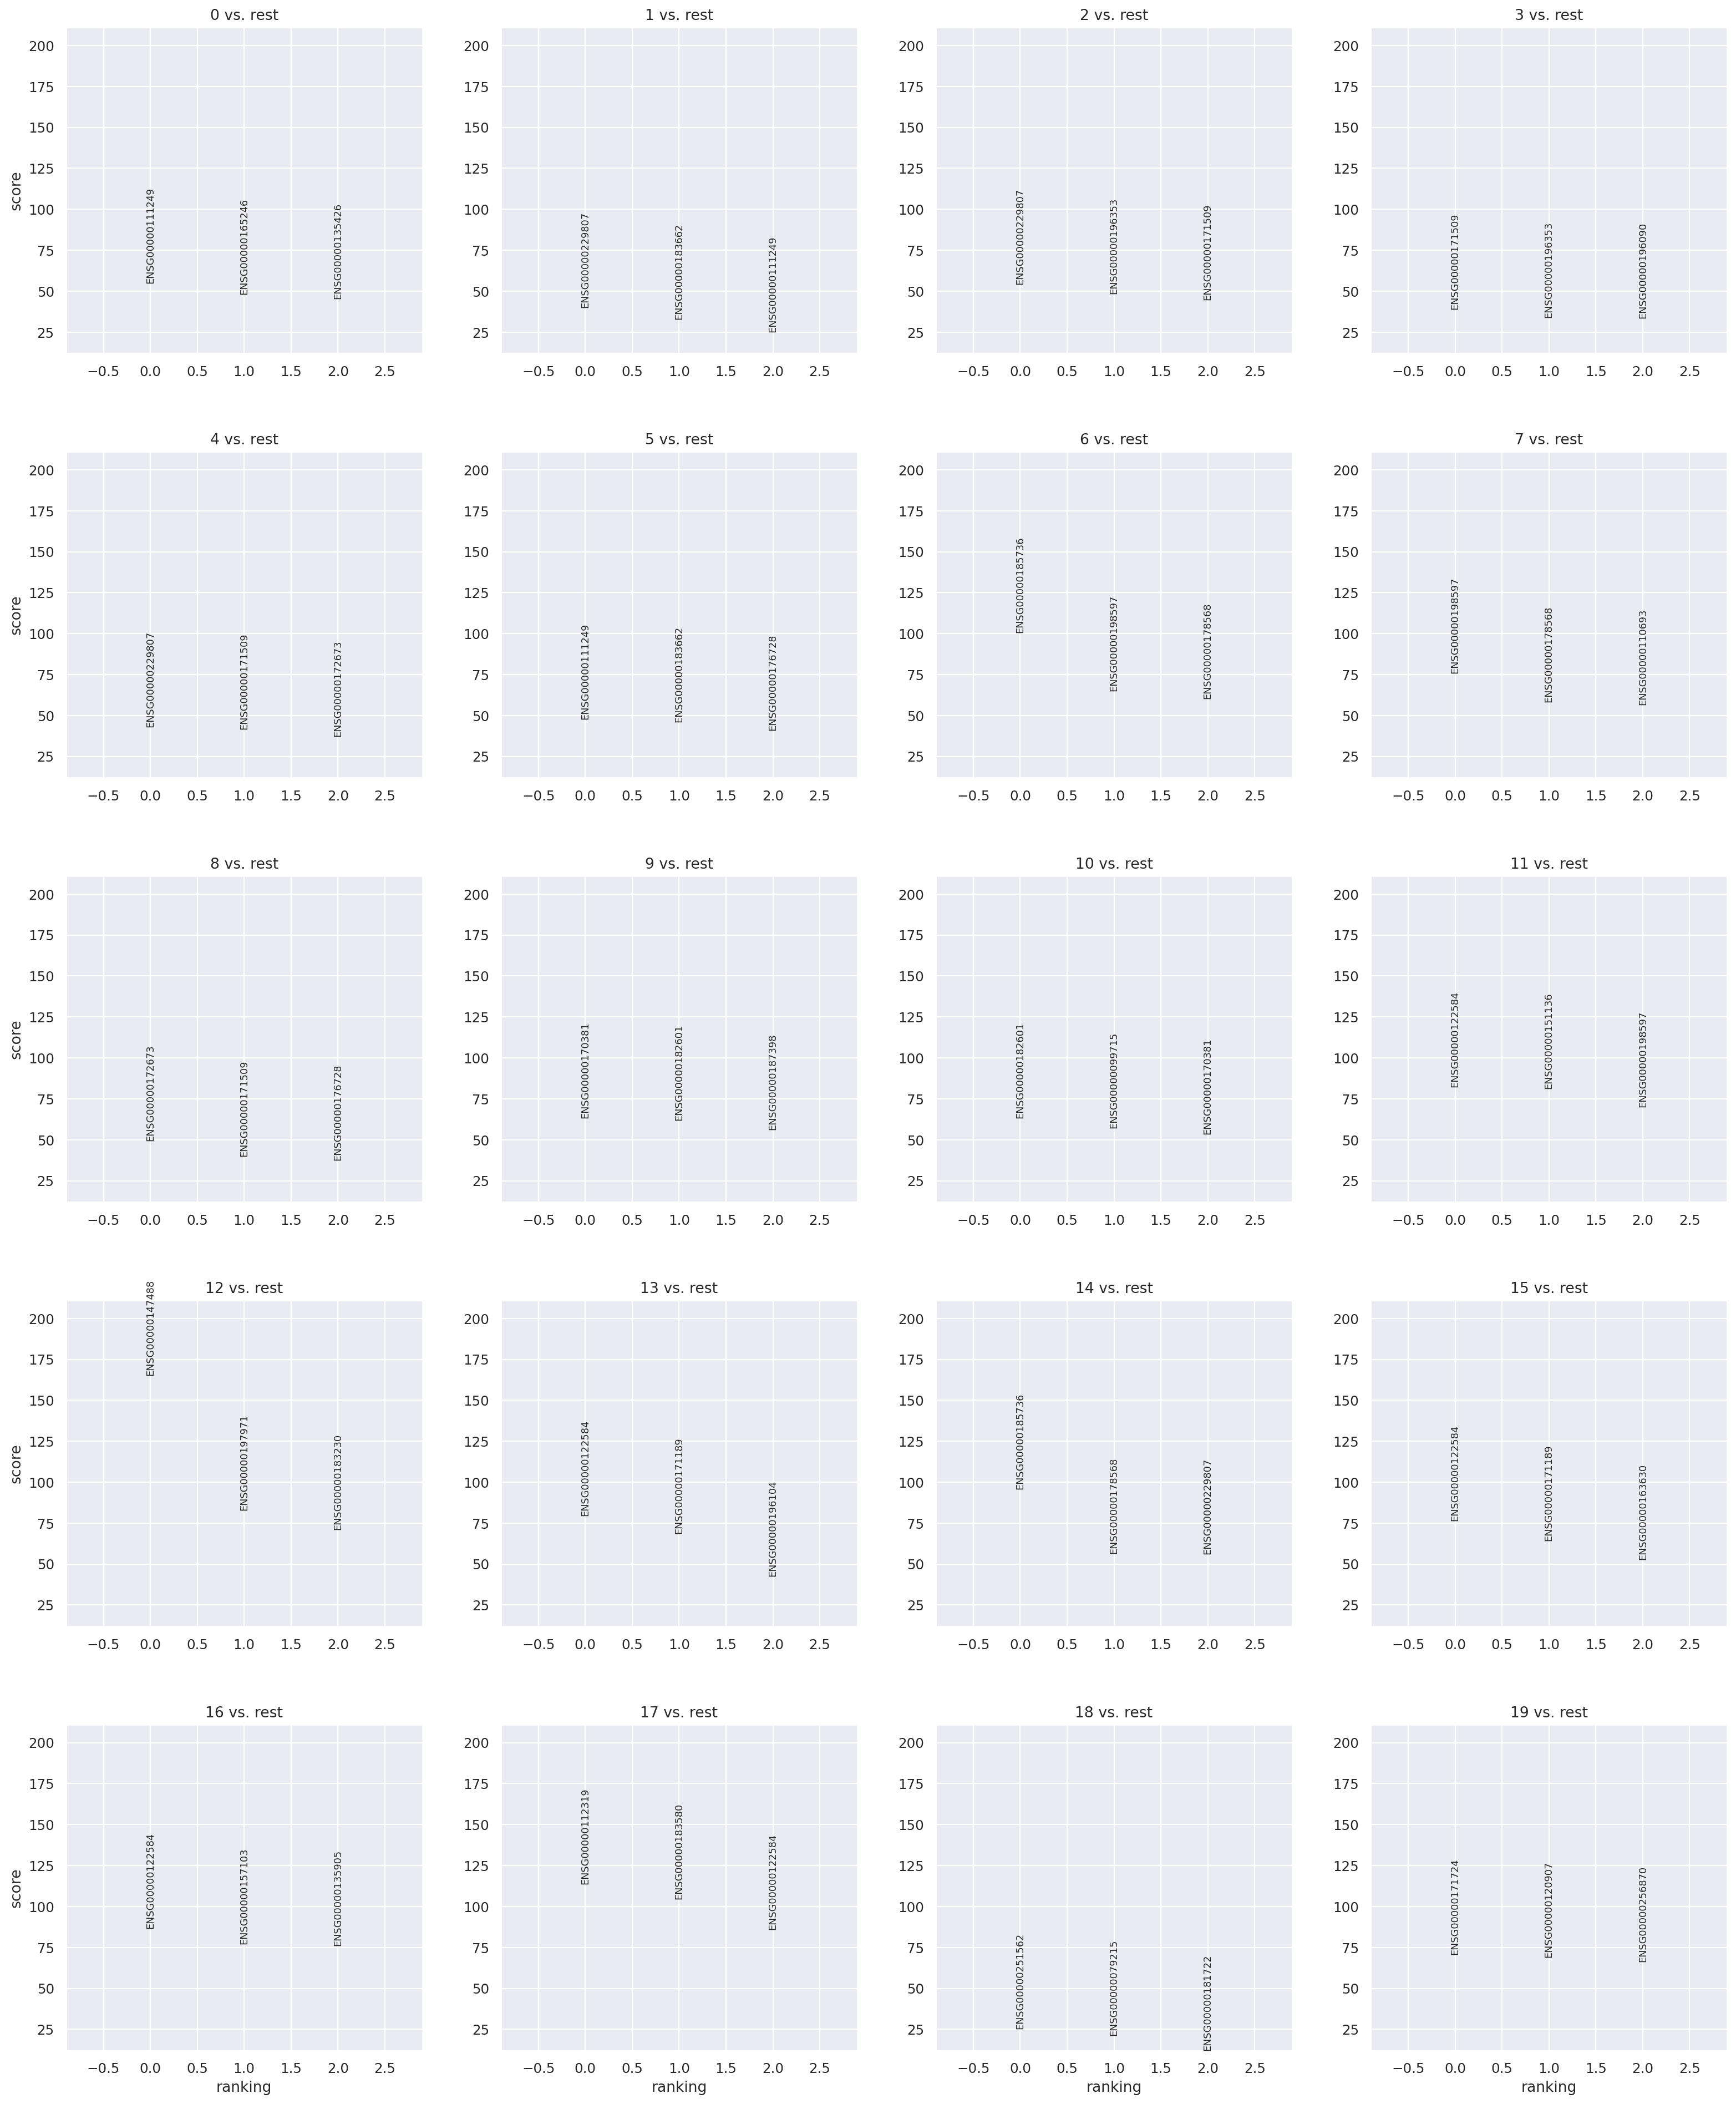

In [126]:
sc.tl.rank_genes_groups(adata, groupby='leiden_scVI', use_raw=True)
sc.pl.rank_genes_groups(adata, n_genes=3)


In [134]:
import pandas as pd

rg = adata.uns['rank_genes_groups']
clusters = rg['names'].dtype.names  # cluster names

for c in clusters:
    scores = rg['scores'][c]
    top_score = max(scores)
    second_score = sorted(scores, reverse=True)[1]
    if top_score > 1.15*(second_score+1e-6):  # arbitrary threshold
        print(f"Cluster {c} dominated by {rg['names'][c][0]} (score {top_score:.2f})")


Cluster 1 dominated by ENSG00000229807 (score 39.80)
Cluster 3 dominated by ENSG00000171509 (score 39.00)
Cluster 6 dominated by ENSG00000185736 (score 100.56)
Cluster 7 dominated by ENSG00000198597 (score 75.89)
Cluster 8 dominated by ENSG00000172673 (score 49.41)
Cluster 12 dominated by ENSG00000147488 (score 165.20)
Cluster 13 dominated by ENSG00000122584 (score 79.60)
Cluster 14 dominated by ENSG00000185736 (score 95.77)
Cluster 15 dominated by ENSG00000122584 (score 76.42)
Cluster 18 dominated by ENSG00000251562 (score 25.22)


# Dominated Gene Functions and Classifications

## Cluster 1: ENSG00000229807 (XIST)
- **Function:** XIST is a long non-coding RNA (lncRNA) responsible for X-chromosome inactivation in females. It coats the inactive X chromosome, leading to its silencing.  
- **Classification:** LncRNA  
- **Biological Significance:** XIST's role in X-inactivation is crucial for dosage compensation between sexes.

## Cluster 3: ENSG00000171509 (RXFP1)
- **Function:** RXFP1 encodes a receptor for the hormone relaxin, involved in processes like sperm motility, pregnancy, and parturition.  
- **Classification:** Protein-coding gene  
- **Biological Significance:** Its expression in the brain suggests potential roles in neuroendocrine signaling.

## Cluster 6: ENSG00000185736 (ADARB2)
- **Function:** ADARB2 is an RNA-editing enzyme that modifies double-stranded RNA, influencing gene expression and neuronal function.  
- **Classification:** Protein-coding gene  
- **Biological Significance:** Its expression in the brain indicates a role in neural development and function.

## Cluster 7: ENSG00000198597 (ZNF536)
- **Function:** ZNF536 is a zinc finger protein that acts as a transcriptional repressor, negatively regulating neuronal differentiation.  
- **Classification:** Protein-coding gene  
- **Biological Significance:** Its role in repressing retinoic acid-induced gene transcription suggests involvement in neural development.

## Cluster 8: ENSG00000172673 (THEMIS)
- **Function:** THEMIS plays a central role in late thymocyte development by regulating T-cell selection and maturation.  
- **Classification:** Protein-coding gene  
- **Biological Significance:** Its expression in the brain suggests potential roles in neuroimmune interactions.

## Cluster 12: ENSG00000147488 (ST18)
- **Function:** ST18 is a transcriptional repressor that binds to specific DNA sequences, regulating gene expression.  
- **Classification:** Protein-coding gene  
- **Biological Significance:** Its role in repressing basal transcription activity suggests involvement in cellular differentiation processes.

## Cluster 13: ENSG00000122584 (NXPH1)
- **Function:** NXPH1 encodes a secreted protein that forms complexes with neurexins, promoting adhesion between dendrites and axons.  
- **Classification:** Protein-coding gene  
- **Biological Significance:** Its expression in the brain indicates a role in synaptic signaling and neuronal connectivity.

## Cluster 14: ENSG00000185736 (ADARB2)
- **Function:** As mentioned above, ADARB2 is involved in RNA editing and regulation of gene expression.  
- **Classification:** Protein-coding gene  
- **Biological Significance:** Its expression in the brain suggests a role in neural development and function.

## Cluster 15: ENSG00000122584 (NXPH1)
- **Function:** NXPH1 observed also in Cluster \# 13 is involved in synaptic signaling and neuronal connectivity.  
- **Classification:** Protein-coding gene  
- **Biological Significance:** Its expression in the brain indicates a role in synaptic function.

## Cluster 18: ENSG00000251562 (MALAT1)
- **Function:** MALAT1 is a long non-coding RNA that regulates gene expression and cell motility.  
- **Classification:** LncRNA  
- **Biological Significance:** Its expression in the brain suggests roles in neural development and function.
